# __Boston Housing Prices Prediction__
#### Project by Nikolas White

### __Data Collection/Preprocessing__

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from a CSV file
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)

# Split the dataset into training and testing sets
X = df.drop('medv', axis=1)
y = df['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames to maintain feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Save the processed data
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_test_scaled.to_csv('X_test_scaled.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)



### __Exploratory Data Analysis__ 

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'PRICE'],
      dtype='object')


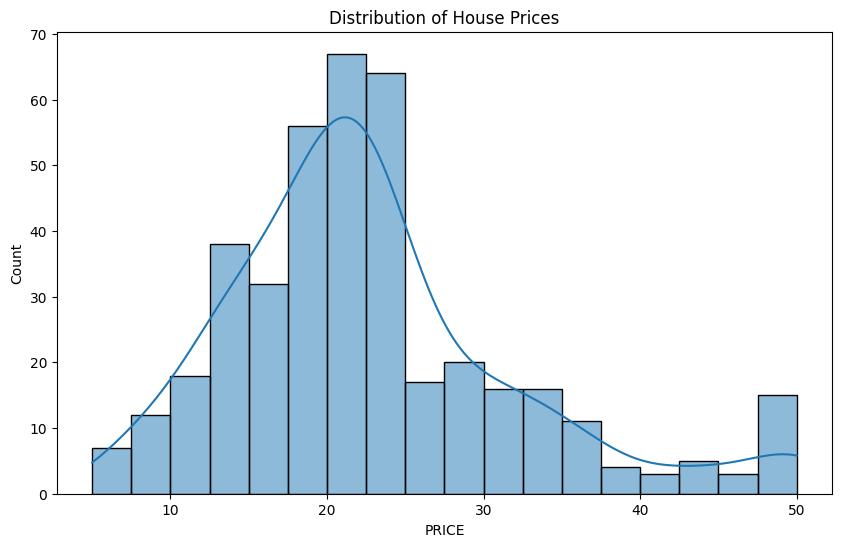

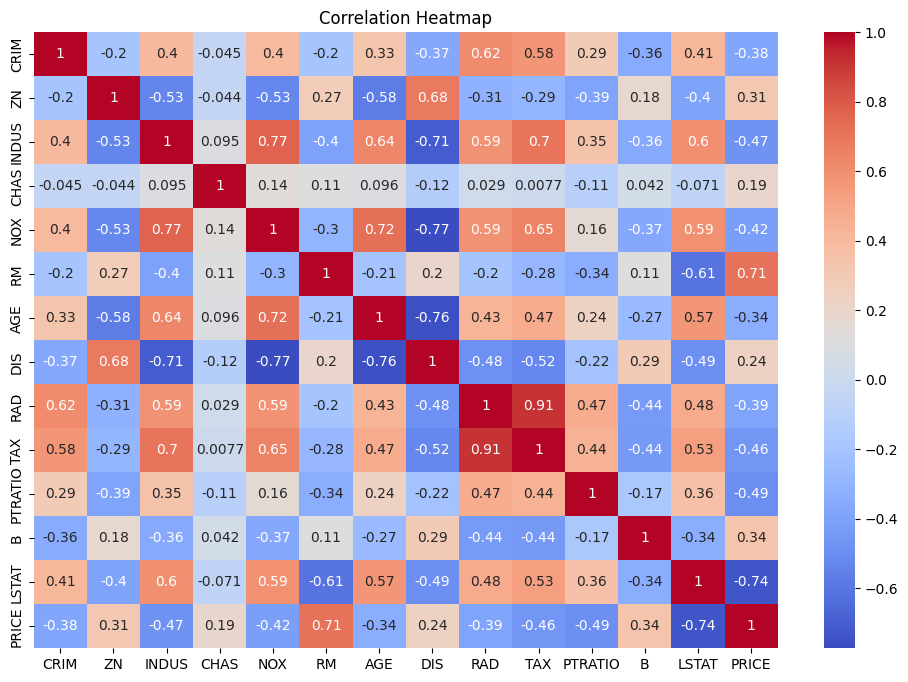

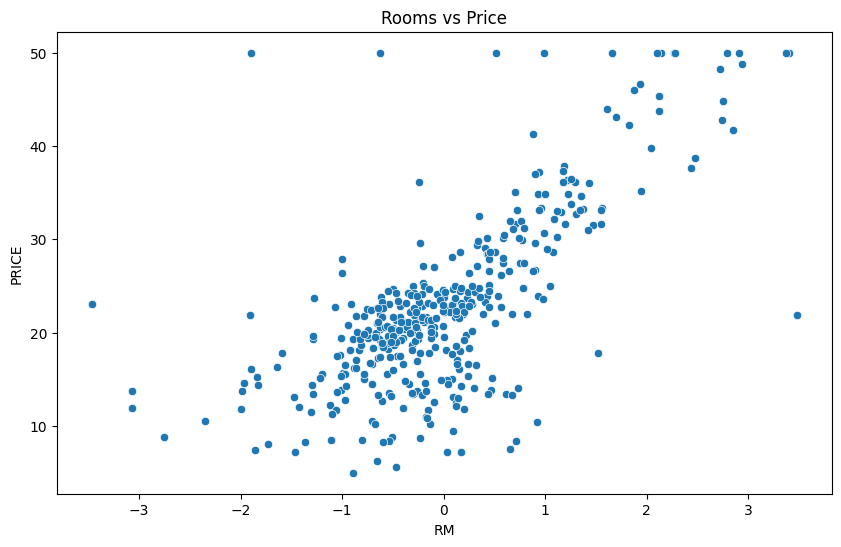

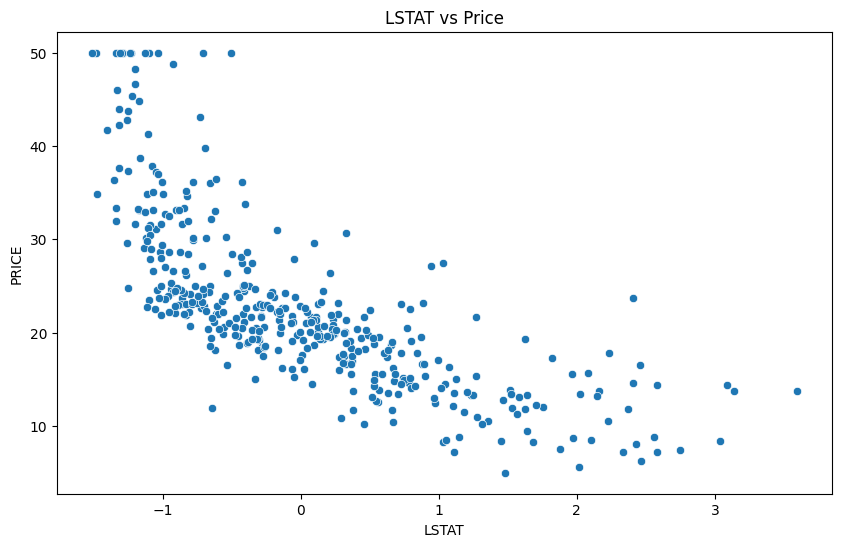

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('X_train_scaled.csv')
df['PRICE'] = pd.read_csv('y_train.csv')

# Check the column names
print(df.columns)

# If columns need renaming to match the original dataset
df.rename(columns={
    'crim': 'CRIM', 'zn': 'ZN', 'indus': 'INDUS', 'chas': 'CHAS', 'nox': 'NOX',
    'rm': 'RM', 'age': 'AGE', 'dis': 'DIS', 'rad': 'RAD', 'tax': 'TAX',
    'ptratio': 'PTRATIO', 'b': 'B', 'lstat': 'LSTAT', 'medv': 'PRICE'
}, inplace=True)

# Distribution of Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['PRICE'], kde=True)
plt.title('Distribution of House Prices')
plt.savefig('distribution_of_house_prices.png')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

# Scatter plot of some key features vs Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RM', y='PRICE', data=df)
plt.title('Rooms vs Price')
plt.savefig('rooms_vs_price.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='LSTAT', y='PRICE', data=df)
plt.title('LSTAT vs Price')
plt.savefig('lstat_vs_price.png')
plt.show()


### __Feature Engineering__

In [19]:
from sklearn.preprocessing import PolynomialFeatures

# Load the original dataset and target variable
X_train_scaled = pd.read_csv('X_train_scaled.csv')
X_test_scaled = pd.read_csv('X_test_scaled.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Add polynomial features to both training and test sets
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Save the processed data
pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(X_train_scaled.columns)).to_csv('X_train_poly.csv', index=False)
pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(X_train_scaled.columns)).to_csv('X_test_poly.csv', index=False)
y_train.to_csv('y_train_poly.csv', index=False)
y_test.to_csv('y_test_poly.csv', index=False)

### __Model Building/Evaluation__

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the processed data
X_train = pd.read_csv('X_train_poly.csv')
X_test = pd.read_csv('X_test_poly.csv')
y_train = pd.read_csv('y_train_poly.csv').values.ravel()
y_test = pd.read_csv('y_test_poly.csv').values.ravel()

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'R2 Score': r2_score(y_test, y_pred)
    }

# Save model results
results_df = pd.DataFrame(results).T
results_df.to_csv('model_results.csv')

# Print results
print(results_df)


                         MSE  R2 Score
Linear Regression  14.257338  0.805583
Decision Tree       7.982059  0.891154
Random Forest      10.805932  0.852647
Gradient Boosting   9.436169  0.871326


### __Model Interpretation__

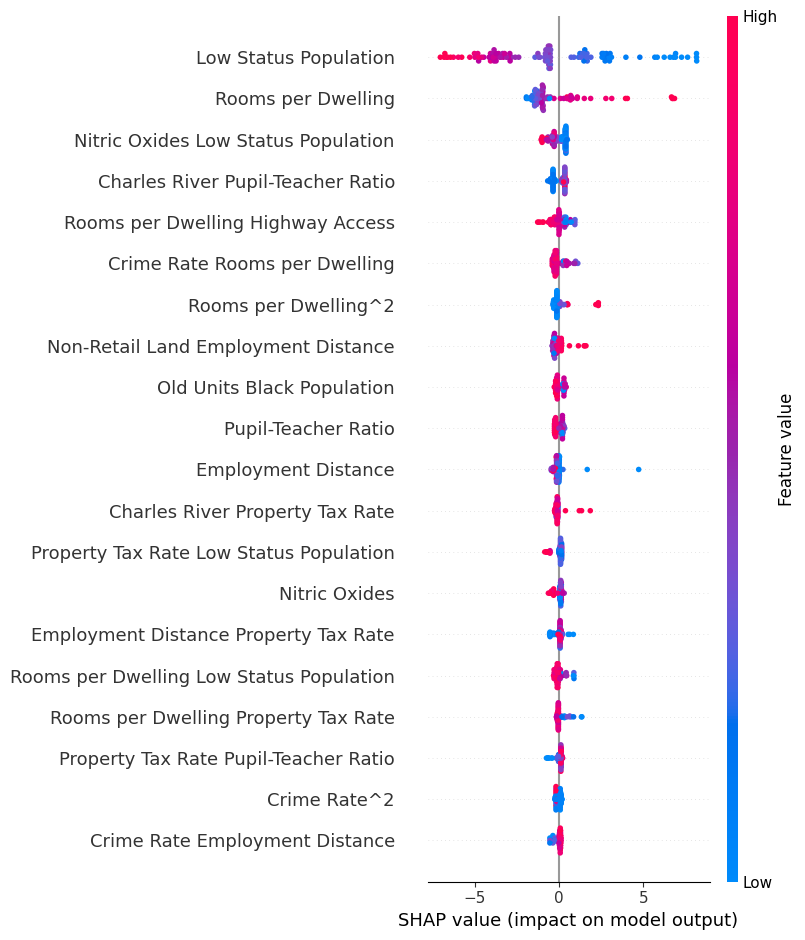

In [22]:
import shap

# Load the processed data
X_train = pd.read_csv('X_train_poly.csv')
X_test = pd.read_csv('X_test_poly.csv')
y_train = pd.read_csv('y_train_poly.csv').values.ravel()
y_test = pd.read_csv('y_test_poly.csv').values.ravel()

# Load the best model (Gradient Boosting performed best)
best_model = GradientBoostingRegressor()
best_model.fit(X_train, y_train)

# Mapping of original features to more descriptive names
feature_names_mapping = {
    'crim': 'Crime Rate',
    'zn': 'Residential Land',
    'indus': 'Non-Retail Land',
    'chas': 'Charles River',
    'nox': 'Nitric Oxides',
    'rm': 'Rooms per Dwelling',
    'age': 'Old Units',
    'dis': 'Employment Distance',
    'rad': 'Highway Access',
    'tax': 'Property Tax Rate',
    'ptratio': 'Pupil-Teacher Ratio',
    'b': 'Black Population',
    'lstat': 'Low Status Population'
}

# Get the original feature names from PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(pd.read_csv('X_train_scaled.csv'))
poly_features = poly.get_feature_names_out()

# Map the polynomial feature names to more descriptive names
descriptive_features = []
for feature in poly_features:
    for orig_name, desc_name in feature_names_mapping.items():
        feature = feature.replace(orig_name, desc_name)
    descriptive_features.append(feature)

# Explain the model's predictions using SHAP
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# Plot SHAP values with updated feature names and save the plot as a PNG file
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=descriptive_features, show=False)
plt.savefig('shap_summary_plot.png')
plt.show()


### __Feature Dictionary__

- **Low Status Population**: Percentage of the population considered to have low socio-economic status, often measured by factors such as income, education, and occupation.

- **Rooms per Dwelling**: Average number of rooms per residential unit. This can indicate the size and capacity of homes in the area.

- **Rooms per Dwelling^2**: The square of the average number of rooms per residential unit. This is used to capture non-linear effects of room count on house prices.

- **Nitric Oxides Low Status Population**: Interaction term between the concentration of nitric oxides in the air (parts per 10 million) and low status population. This measures the combined effect of air pollution and socio-economic status on housing prices.

- **Charles River Pupil-Teacher Ratio**: Interaction term between proximity to the Charles River and the pupil-teacher ratio in local schools. The Charles River is a major river in eastern Massachusetts, and living near it can be a desirable feature. The pupil-teacher ratio is the number of students per teacher in local schools, reflecting the quality of education.

- **Crime Rate Rooms per Dwelling**: Interaction term between the crime rate in the area and the average number of rooms per residential unit. This measures how crime levels impact the desirability of larger homes.

- **Rooms per Dwelling Highway Access**: Interaction term between the average number of rooms per residential unit and the accessibility to highways. This indicates the combined effect of home size and ease of transportation on house prices.

- **Pupil-Teacher Ratio**: The number of students per teacher in local schools. Lower ratios typically indicate better educational quality.

- **Non-Retail Land Employment Distance**: Interaction term between the proportion of non-retail business acres per town and the distance to employment centers. This measures the combined effect of industrial land use and job accessibility on housing prices.

- **Nitric Oxides**: Concentration of nitric oxides in the air (parts per 10 million). Higher levels indicate more air pollution, which can negatively impact housing prices.

- **Old Units Black Population**: Interaction term between the proportion of old housing units (built before 1940) and the proportion of Black residents. This captures the combined effect of housing age and racial demographics on house prices.

- **Employment Distance**: Weighted distances to five major employment centers in Boston. Shorter distances generally make an area more desirable for commuters.

- **Charles River Property Tax Rate**: Interaction term between proximity to the Charles River and the property tax rate. This captures the combined effect of river proximity and tax burden on housing prices.

- **Property Tax Rate Low Status Population**: Interaction term between the property tax rate and the percentage of the population with low socio-economic status. This measures how tax burdens affect lower-income populations.

- **Employment Distance Property Tax Rate**: Interaction term between the distance to employment centers and the property tax rate. This indicates how accessibility to jobs and tax burdens together impact housing prices.

- **Rooms per Dwelling Low Status Population**: Interaction term between the average number of rooms per residential unit and the percentage of the population with low socio-economic status. This measures how home size and socio-economic status together affect housing prices.

- **Rooms per Dwelling Property Tax Rate**: Interaction term between the average number of rooms per residential unit and the property tax rate. This captures the combined effect of home size and tax burden on housing prices.

- **Property Tax Rate Pupil-Teacher Ratio**: Interaction term between the property tax rate and the pupil-teacher ratio. This measures how tax burdens and educational quality together impact housing prices.

- **Crime Rate Low Status Population**: Interaction term between the crime rate and the percentage of the population with low socio-economic status. This indicates the combined effect of crime and socio-economic status on housing prices.

- **Crime Rate Employment Distance**: Interaction term between the crime rate and the distance to employment centers. This captures the combined effect of crime and job accessibility on housing prices.


### __Key Takeaways__

#### __Socio-Economic Status:__

The low status population is the most influential factor in predicting house prices. Areas with higher proportions of low socio-economic status populations tend to have lower house prices. This highlights the significant impact of socio-economic conditions on property values.

#### __Home Size and Features:__

The average number of rooms per dwelling is positively correlated with house prices. Larger homes with more rooms are generally more valuable.
The square of the average number of rooms per dwelling captures non-linear effects, indicating that the impact of room count on price may change as the number of rooms increases.

#### __Environmental Quality:__

Nitric oxides concentration negatively impacts house prices. Higher levels of air pollution are associated with lower property values.
The interaction between nitric oxides and low status population shows that areas with both high pollution and low socio-economic status are particularly devalued.

#### __Education Quality:__

The pupil-teacher ratio is an important factor, with lower ratios (indicating better education quality) being associated with higher house prices.
The interaction between proximity to the Charles River and the pupil-teacher ratio suggests that areas near the river with good schools are highly valued.

#### __Crime and Safety:__

Crime rate negatively affects house prices, especially in larger homes and areas with low socio-economic status populations. Safety concerns significantly reduce the desirability of properties.

#### __Accessibility and Transportation:__

Employment distance (distance to job centers) is a crucial factor. Properties closer to employment centers are more desirable and have higher prices.
Highway access combined with home size also positively impacts house prices, reflecting the importance of convenient transportation.

#### __Property Taxes:__

Property tax rates influence house prices, with higher taxes generally being a negative factor. However, when combined with other factors like education quality, the impact can be mitigated or even positive.

#### __Historical and Demographic Factors:__

Old units and racial demographics (interaction between old housing units and Black population) reflect historical and socio-economic complexities that can affect property values.
Interaction terms involving various combinations of socio-economic status, crime rates, and demographic factors provide a nuanced understanding of how these variables jointly influence house prices.